# Import commands

In [30]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# Data cleaning and preprocessing

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\ladhe\CDAC Project\Potato Dieases Classification\Data cleaning and training\plantvillage dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68


## Data visualization

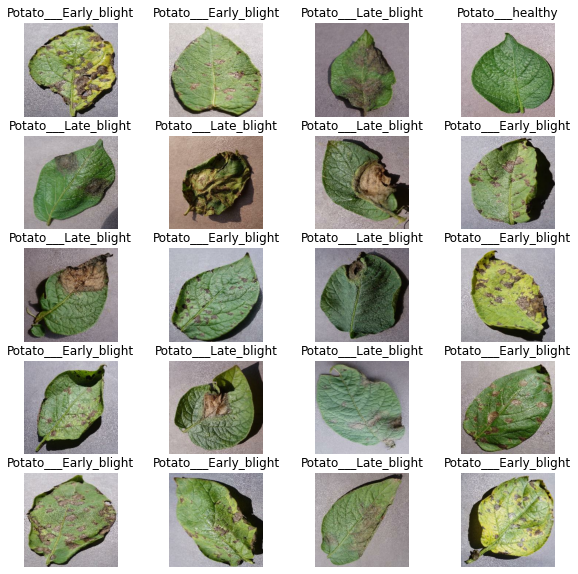

In [8]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## train-test-val split

In [9]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 24)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Building

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 97s 2s/step - loss: 0.9129 - accuracy: 0.5451 - val_loss: 0.7147 - val_accuracy: 0.7760
Epoch 2/50
54/54 [==============================] - 87s 2s/step - loss: 0.5495 - accuracy: 0.8119 - val_loss: 0.4339 - val_accuracy: 0.8333
Epoch 3/50
54/54 [==============================] - 88s 2s/step - loss: 0.4060 - accuracy: 0.8380 - val_loss: 0.3433 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 124s 2s/step - loss: 0.3280 - accuracy: 0.8594 - val_loss: 0.3734 - val_accuracy: 0.7865
Epoch 5/50
54/54 [==============================] - 103s 2s/step - loss: 0.2855 - accuracy: 0.8837 - val_loss: 0.2367 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 96s 2s/step - loss: 0.2451 - accuracy: 0.9005 - val_loss: 0.2432 - val_accuracy: 0.8698
Epoch 7/50
54/54 [==============================] - 99s 2s/step - loss: 0.2012 - accuracy: 0.9242 - val_loss: 0.1386 - val_accuracy: 0.9375
Epoch 8/50
54/54 [

In [21]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 392ms/step - loss: 0.0933 - accuracy: 0.9688


In [22]:
scores

[0.09325698763132095, 0.96875]

In [23]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

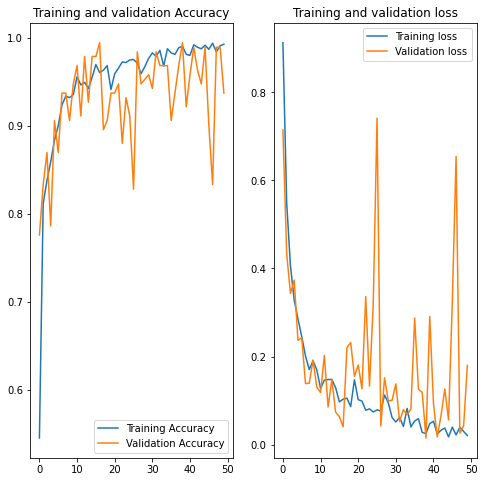

In [26]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation loss')
plt.show()

In [27]:
# import numpy as np
# for images_batch, labels_batch in test_ds.take(1):
    
#     first_image = images_batch[0].numpy().asstype('uint8')
#     first_label = labels_batch[0].numpy()
    
#     print('First image to predict')
#     plt.imshow(first_image)
#     print('actual label:', class_names[first_label]
    
#     batch_prediction = model.predict(images_batch)
#     print('predicted label:', class_names[np.argmax{batch_prediction[0]}])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

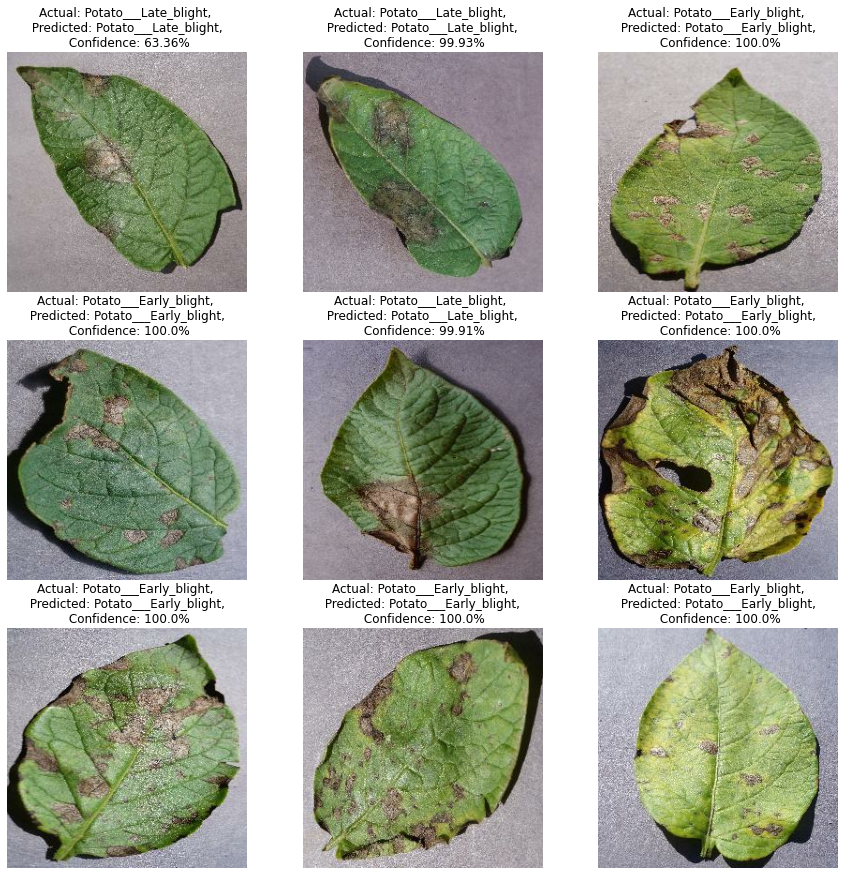

In [31]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%')
        
        plt.axis('off')

In [32]:
import os
model_version = max([int(i) for i in os.listdir('../trained_models') + [0]]) + 1
model.save(f'../trained_models/{model_version}')

INFO:tensorflow:Assets written to: ../trained_models/1\assets
